## CIFAR-10 UAP - Evaluation
We show examples of the following:
1. Evaluation on clean datasets (train, test)
2. Evaluation with chess noise pattern
3. Loading and evaluation on pre-computed UAP

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch

sys.path.append(os.path.realpath('..'))

from utils import loader_cifar, model_cifar, evaluate

# dir_data = '/data/cifar10'
dir_uap = '../uaps/cifar10/'

# testloader = loader_cifar(dir_data = dir_data, train = False)
# trainloader = loader_cifar(dir_data = dir_data, train = True)

In [13]:
# input_tensor = None
# label_tensor = None

# for batch in testloader:
#     # extract the inputs and labels from the batch
#     inputs, labels = batch

#     # concatenate the inputs and labels into a single tensor
#     if input_tensor is None:
#         input_tensor = inputs
#         label_tensor = labels
#     else:
#         input_tensor = torch.cat((input_tensor, inputs))
#         label_tensor = torch.cat((label_tensor, labels))

In [14]:
from robustbench.data import load_cifar10
import json

x_test, y_test = load_cifar10()

with open('config_ids_source_targets.json','r') as f:
    config = json.load(f)
    
ids = config['ids']
x_test_correct , y_test_correct = x_test[ids,:,:,:] , y_test[ids]

Files already downloaded and verified


In [23]:
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_example = self.inputs[idx]
        label_example = self.labels[idx]
        return input_example, label_example

my_dataset = MyDataset(x_test_correct, y_test_correct)

batch_size = 10
#num_workers = 4
test_loader = DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

## 1. Clean

In [7]:
from robustbench.utils import load_model, clean_accuracy
model = load_model(model_name='Carmon2019Unlabeled', dataset='cifar10', threat_model='Linf')
# best_acc = clean_accuracy(model, input_tensor, label_tensor)
# print(best_acc)

In [33]:
#accuracy should be equal to 1
test_acc = clean_accuracy(model, x_test_correct, y_test_correct)
print(test_acc)

1.0


In [17]:
# load model
# model, best_acc = model_cifar('resnet18', ckpt_path = '../resnet18.pth')
# print(best_acc)

In [10]:
# _, _, _, _, outputs, labels = evaluate(model, testloader, uap = None)
# print('Test accuracy:', sum(outputs == labels) / len(labels))

## 2. Chessboard pattern

In [19]:
# load pattern
uap = torch.load(dir_uap + 'chess.pth')
uap.to('cpu')

tensor([[[-1.,  1., -1.,  ...,  1., -1.,  1.],
         [ 1., -1.,  1.,  ..., -1.,  1., -1.],
         [-1.,  1., -1.,  ...,  1., -1.,  1.],
         ...,
         [ 1., -1.,  1.,  ..., -1.,  1., -1.],
         [-1.,  1., -1.,  ...,  1., -1.,  1.],
         [ 1., -1.,  1.,  ..., -1.,  1., -1.]],

        [[-1.,  1., -1.,  ...,  1., -1.,  1.],
         [ 1., -1.,  1.,  ..., -1.,  1., -1.],
         [-1.,  1., -1.,  ...,  1., -1.,  1.],
         ...,
         [ 1., -1.,  1.,  ..., -1.,  1., -1.],
         [-1.,  1., -1.,  ...,  1., -1.,  1.],
         [ 1., -1.,  1.,  ..., -1.,  1., -1.]],

        [[-1.,  1., -1.,  ...,  1., -1.,  1.],
         [ 1., -1.,  1.,  ..., -1.,  1., -1.],
         [-1.,  1., -1.,  ...,  1., -1.,  1.],
         ...,
         [ 1., -1.,  1.,  ..., -1.,  1., -1.],
         [-1.,  1., -1.,  ...,  1., -1.,  1.],
         [ 1., -1.,  1.,  ..., -1.,  1., -1.]]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


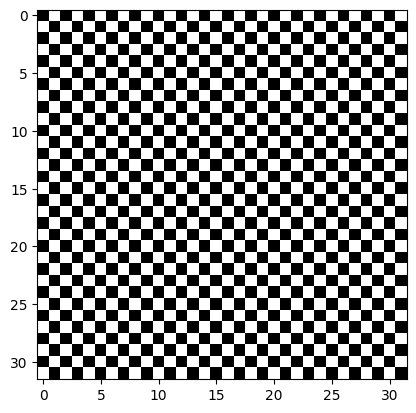

In [21]:
# visualize chessboard
plt.imshow(np.transpose(uap, (1, 2, 0)))

In [25]:
# evaluate
eps = 8 / 255
_, _, _, _, outputs, labels = evaluate(model, test_loader, uap = uap * eps)
print('Robust accuracy:', sum(outputs == labels) / len(labels))

Robust accuracy: 1.0


(array([10.,  8.,  7.,  9.,  7.,  6., 18., 12., 13., 10.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

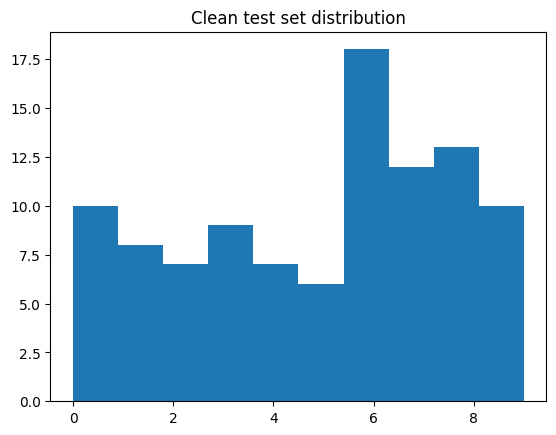

In [26]:
plt.title('Clean test set distribution')
plt.hist(labels)

(array([10.,  8.,  7.,  9.,  7.,  6., 18., 12., 13., 10.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

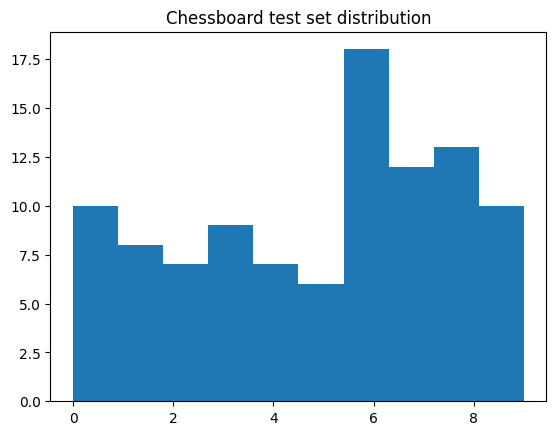

In [27]:
# plot histogram
plt.title('Chessboard test set distribution')
plt.hist(outputs)

## 3. Pre-computed UAP

In [28]:
# load UAP targeting class 4 with eps = 10
y_target = 4
eps = 10
uap = torch.load(dir_uap + 'sgd-tgt%i-eps%i.pth' % (y_target, eps))

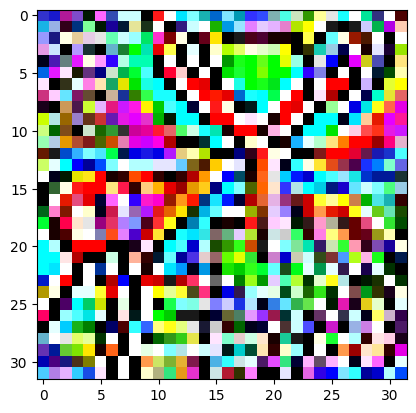

In [29]:
# visualize UAP
uap_max = torch.max(uap)
plt.imshow(np.transpose(((uap / uap_max) + 1) / 2, (1, 2, 0)))

In [31]:
# evaluate
_, _, _, _, outputs, labels = evaluate(model, test_loader, uap = uap)
print('Robust accuracy:', sum(outputs == labels) / len(labels))
print('Targeted success rate:', sum(outputs == y_target) / len(labels))

Robust accuracy: 1.0
Targeted success rate: 0.07


(array([10.,  8.,  7.,  9.,  7.,  6., 18., 12., 13., 10.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

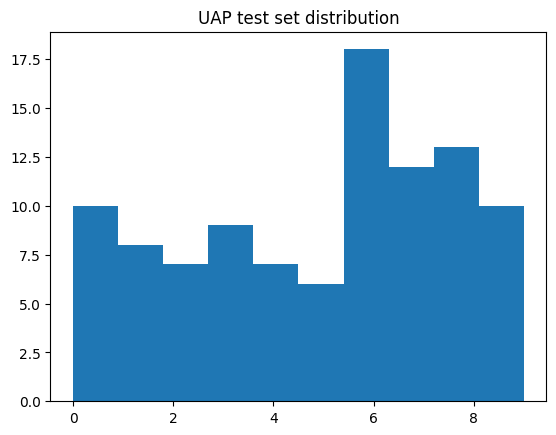

In [32]:
# plot histogram
plt.title('UAP test set distribution')
plt.hist(outputs)